In [1]:
# Import necessary libraries
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear
from torch_geometric.nn import NNConv
import torch.nn.functional as F
from tqdm import tqdm

C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:85: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:123: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the s

In [2]:
# %% Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# %% Load data from MATLAB files
num_instances = 10
data_list = []

for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    # Extract positions and signal strength
    node_latitudes = mat_data['nodeLatitudes'].flatten()
    node_longitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    # Number of nodes
    num_nodes = len(node_latitudes)

    # Create truth locations (latitude and longitude converted to x, y coordinates)
    truth_location_list = np.column_stack((node_latitudes, node_longitudes))

    # Compute distances and create edge attributes
    edge_index_list = []
    edge_attr_list = []

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                edge_attr_list.append(signal_strength_matrix[i, j, :])  # Use all 10 simulated measurements
    
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Create node features
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:25] = True  # First 25 nodes are anchors
    unknown_mask = ~anchor_mask

    # Node features: coordinates and anchor flag (1 for anchor, 0 for unknown)
    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < 25 else 0
        node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])
    x = torch.tensor(node_features, dtype=torch.float)

    # Labels (ground truth positions)
    y = torch.tensor(truth_location_list, dtype=torch.float)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    data_list.append(data)

Loading MATLAB data:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Temp\ipykernel_63056\2701398546.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
Loading MATLAB data: 100%|██████████| 10/10 [00:00<00:00, 41.49it/s]


In [4]:
# %% Normalize features using StandardScaler
all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
scaler = StandardScaler()
scaler.fit(all_features)

for data in data_list:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

# %% Create DataLoader
train_loader = DataLoader(data_list, batch_size=2, shuffle=True)

C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# %% Define GCN model
class EdgeFeatureNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EdgeFeatureNet, self).__init__()
        self.net = Sequential(
            Linear(input_dim, 64),
            torch.nn.ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_feature_dim, num_measurements):
        super(GCN, self).__init__()
        # Edge feature network to process time-series edge attributes
        self.edge_net = EdgeFeatureNet(num_measurements, edge_feature_dim)
        
        # Edge networks for NNConv layers
        nn1 = Sequential(Linear(edge_feature_dim, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1, aggr='mean')
        
        nn2 = Sequential(Linear(edge_feature_dim, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        
        self.fc = Linear(hidden_dim, output_dim)
        
        # Projection layers for anchor nodes
        self.anchor_proj1 = Linear(input_dim, hidden_dim)
        self.anchor_proj2 = Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, edge_index, edge_attr, anchor_mask):
        # Process edge attributes using EdgeFeatureNet
        edge_attr_processed = self.edge_net(edge_attr)
        
        # Save the original features of anchor nodes
        x_anchor = x[anchor_mask]
        
        # First GNN layer
        x = self.conv1(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj1(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the projected anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Save the features of anchor nodes after the first layer
        x_anchor = x[anchor_mask]
        
        # Second GNN layer
        x = self.conv2(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj2(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Final fully connected layer
        x = self.fc(x)
        return x

In [6]:
# %% Instantiate model and optimizer
input_dim = data_list[0].x.shape[1]  # Adjust input dimension based on node features
hidden_dim = 64  # Adjust as needed
output_dim = 2   # Predicting x and y coordinates
edge_feature_dim = 32  # Adjust as needed

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, edge_feature_dim=edge_feature_dim, num_measurements=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [7]:
# %% Training loop
model.train()
loss_history = []

for epoch in range(50):
    total_loss = 0

    for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Training Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 1, Loss: 39653.0881


Training Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 52.53it/s]


Epoch 2, Loss: 3059.6310


Training Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 50.26it/s]


Epoch 3, Loss: 3572.7095


Training Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 60.97it/s]


Epoch 4, Loss: 827.1040


Training Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 64.82it/s]


Epoch 5, Loss: 252.5590


Training Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 77.93it/s]


Epoch 6, Loss: 114.0980


Training Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 100.00it/s]


Epoch 7, Loss: 37.7502


Training Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 78.72it/s]


Epoch 8, Loss: 34.5239


Training Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 98.04it/s]


Epoch 9, Loss: 18.7505


Training Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 100.99it/s]


Epoch 10, Loss: 10.7891


Training Epoch 11: 100%|██████████| 5/5 [00:00<00:00, 95.86it/s]


Epoch 11, Loss: 10.7130


Training Epoch 12: 100%|██████████| 5/5 [00:00<00:00, 106.39it/s]


Epoch 12, Loss: 7.1433


Training Epoch 13: 100%|██████████| 5/5 [00:00<00:00, 104.16it/s]


Epoch 13, Loss: 6.0225


Training Epoch 14: 100%|██████████| 5/5 [00:00<00:00, 92.59it/s]


Epoch 14, Loss: 6.8601


Training Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 99.50it/s]


Epoch 15, Loss: 5.3093


Training Epoch 16: 100%|██████████| 5/5 [00:00<00:00, 100.00it/s]


Epoch 16, Loss: 5.5639


Training Epoch 17: 100%|██████████| 5/5 [00:00<00:00, 103.07it/s]


Epoch 17, Loss: 7.2389


Training Epoch 18: 100%|██████████| 5/5 [00:00<00:00, 111.11it/s]


Epoch 18, Loss: 6.6951


Training Epoch 19: 100%|██████████| 5/5 [00:00<00:00, 109.87it/s]


Epoch 19, Loss: 5.9415


Training Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 108.69it/s]


Epoch 20, Loss: 4.9443


Training Epoch 21: 100%|██████████| 5/5 [00:00<00:00, 108.69it/s]


Epoch 21, Loss: 4.0214


Training Epoch 22: 100%|██████████| 5/5 [00:00<00:00, 106.29it/s]


Epoch 22, Loss: 4.3712


Training Epoch 23: 100%|██████████| 5/5 [00:00<00:00, 98.03it/s]


Epoch 23, Loss: 4.7287


Training Epoch 24: 100%|██████████| 5/5 [00:00<00:00, 106.23it/s]


Epoch 24, Loss: 5.0833


Training Epoch 25: 100%|██████████| 5/5 [00:00<00:00, 111.10it/s]


Epoch 25, Loss: 5.8612


Training Epoch 26: 100%|██████████| 5/5 [00:00<00:00, 105.25it/s]


Epoch 26, Loss: 7.3653


Training Epoch 27: 100%|██████████| 5/5 [00:00<00:00, 108.69it/s]


Epoch 27, Loss: 5.5640


Training Epoch 28: 100%|██████████| 5/5 [00:00<00:00, 107.52it/s]


Epoch 28, Loss: 5.0742


Training Epoch 29: 100%|██████████| 5/5 [00:00<00:00, 113.64it/s]


Epoch 29, Loss: 4.5999


Training Epoch 30: 100%|██████████| 5/5 [00:00<00:00, 110.92it/s]


Epoch 30, Loss: 3.5968


Training Epoch 31: 100%|██████████| 5/5 [00:00<00:00, 96.15it/s]


Epoch 31, Loss: 3.4578


Training Epoch 32: 100%|██████████| 5/5 [00:00<00:00, 109.86it/s]


Epoch 32, Loss: 3.5404


Training Epoch 33: 100%|██████████| 5/5 [00:00<00:00, 108.70it/s]


Epoch 33, Loss: 4.5891


Training Epoch 34: 100%|██████████| 5/5 [00:00<00:00, 103.07it/s]


Epoch 34, Loss: 3.6230


Training Epoch 35: 100%|██████████| 5/5 [00:00<00:00, 111.11it/s]


Epoch 35, Loss: 3.1092


Training Epoch 36: 100%|██████████| 5/5 [00:00<00:00, 101.41it/s]


Epoch 36, Loss: 3.1781


Training Epoch 37: 100%|██████████| 5/5 [00:00<00:00, 99.98it/s]


Epoch 37, Loss: 3.2126


Training Epoch 38: 100%|██████████| 5/5 [00:00<00:00, 93.54it/s]


Epoch 38, Loss: 3.4867


Training Epoch 39: 100%|██████████| 5/5 [00:00<00:00, 83.05it/s]


Epoch 39, Loss: 3.8618


Training Epoch 40: 100%|██████████| 5/5 [00:00<00:00, 98.07it/s]


Epoch 40, Loss: 6.3407


Training Epoch 41: 100%|██████████| 5/5 [00:00<00:00, 103.69it/s]


Epoch 41, Loss: 6.9732


Training Epoch 42: 100%|██████████| 5/5 [00:00<00:00, 93.13it/s]


Epoch 42, Loss: 8.9322


Training Epoch 43: 100%|██████████| 5/5 [00:00<00:00, 94.13it/s]


Epoch 43, Loss: 8.1441


Training Epoch 44: 100%|██████████| 5/5 [00:00<00:00, 98.94it/s]


Epoch 44, Loss: 11.3374


Training Epoch 45: 100%|██████████| 5/5 [00:00<00:00, 102.11it/s]


Epoch 45, Loss: 10.2969


Training Epoch 46: 100%|██████████| 5/5 [00:00<00:00, 106.64it/s]


Epoch 46, Loss: 21.1001


Training Epoch 47: 100%|██████████| 5/5 [00:00<00:00, 102.16it/s]


Epoch 47, Loss: 17.9761


Training Epoch 48: 100%|██████████| 5/5 [00:00<00:00, 111.05it/s]


Epoch 48, Loss: 20.7772


Training Epoch 49: 100%|██████████| 5/5 [00:00<00:00, 106.12it/s]


Epoch 49, Loss: 10.8544


Training Epoch 50: 100%|██████████| 5/5 [00:00<00:00, 107.77it/s]

Epoch 50, Loss: 4.8387


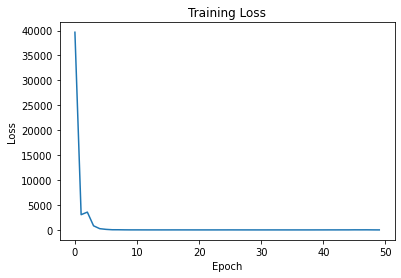

In [8]:
# %% Plot training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Testing GCN: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s]


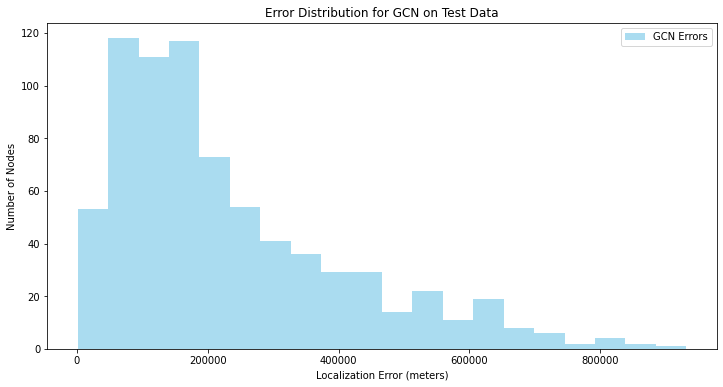

GCN Mean Error: 232825.9853 meters, Median Error: 176487.4338 meters


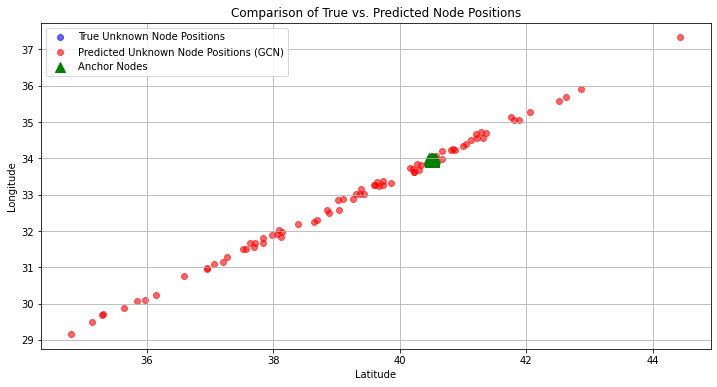

In [22]:
# %% Evaluation and Visualization of GCN Results
from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Haversine distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = (true_positions[idx][0], true_positions[idx][1])
                pred_pos = (predicted_positions[idx][0], predicted_positions[idx][1])
                error = geodesic(true_pos, pred_pos).meters
                errors_gcn.append(error)

# %% Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()


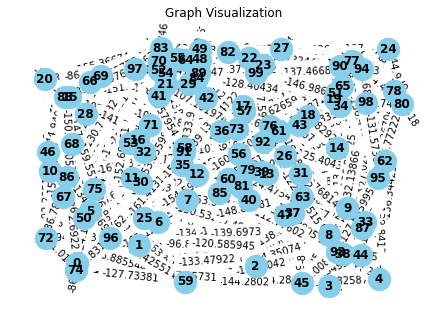